In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
plt.rcParams.update({'text.usetex':True})
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
#from nbodykit.cosmology.power.linear import LinearPower
#from astropy.cosmology import Planck18 as cosmo

In [4]:
import camb
from camb import model, initialpower

In [5]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=68, ombh2=0.022, omch2=0.122, )
pars.InitPower.set_params(As=2.109e-09, ns=0.965)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0.], kmax=10.0)
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
k, z, P = results.get_matter_power_spectrum(minkh=1e-4, maxkh=10, npoints = 5000)
P = P[0]

In [6]:
#k = np.logspace(-5, 2, 1000)
#P = LinearPower(cosmo, 0, transfer='CLASS')(k_class)

In [8]:
from mcfit import TophatVar

from scipy.interpolate import CubicSpline
#varR = CubicSpline(R, var)
#sigmaR = CubicSpline(R, np.sqrt(var))#*1.03)

In [ ]:
#sigmaR(8)

In [11]:
R_array = np.geomspace(5, 85, 1000)

In [27]:
'''def f_ln_sigma(R):
    
    X = x(R)
    #if X<=0.276:
    #    out = (np.sqrt(2/np.pi)*abs(delta_v)/sigmaR(R)
    #           *np.exp(-delta_v**2/2/sigmaR(R)**2))
    #else:
    out = np.array([np.exp(-(j*np.pi*X)**2/2)*j*np.pi*X**2*np.sin(j*np.pi*D) 
                        for j in range(1, 50)])
    out = np.sum(out) * 2
    return out'''


def VSF_model(bias, klinear, Plinear, B_slope=0.96, B_offset=0.26):
    R, var = TophatVar(klinear, lowring=True)(Plinear, extrap=True)
    varR = CubicSpline(R, var)
    sigmaR = CubicSpline(R, np.sqrt(var))
    print(f"sigma8 = {sigmaR(8)}")
    
    F_of_b = lambda b: B_slope * bias + B_offset
    b_punct = lambda beff: 0.854*beff+0.420
    
    delta_c = 1.686 # 1.686
    delta_v = -0.7 #-0.7 #-2.71 # try value
    delta_v /= b_punct(bias) # F_of_b() # divide by tracer bias
    C = 1.594
    delta_v_lin = C * (1-(1+delta_v)**-(1/C))
    D = abs(delta_v_lin) / (delta_c+abs(delta_v_lin))
    x = lambda R: D * sigmaR(R) / abs(delta_v_lin)
    f_ln_sigma = lambda R: 2*np.sum([np.exp(-(j*np.pi*x(R))**2/2)*j*np.pi*x(R)**2*np.sin(j*np.pi*D) 
                                     for j in range(1, 50)])
    
    
    V = lambda R: 4/3*np.pi * R**3
    r_L = lambda R: (1+delta_v_lin)**(1/3) * R # Lagrangian radius
    
    sigma_array = sigmaR(R_array)
    #dlnsigma_dR = CubicSpline(R_array, np.gradient(np.log(sigma_array), R_array))
    dlnsigma_dR = CubicSpline(r_L(R_array), np.gradient(np.log(sigmaR(r_L(R_array))), r_L(R_array)))
    dlnsigma_dlnR = lambda R: dlnsigma_dR(R)*R
    
    
    
    model = -dlnsigma_dlnR(r_L(R_array)) * np.array([f_ln_sigma(R) for R in R_array])/V(R_array)
    
    return model

sigma8 = 0.8256903183974752


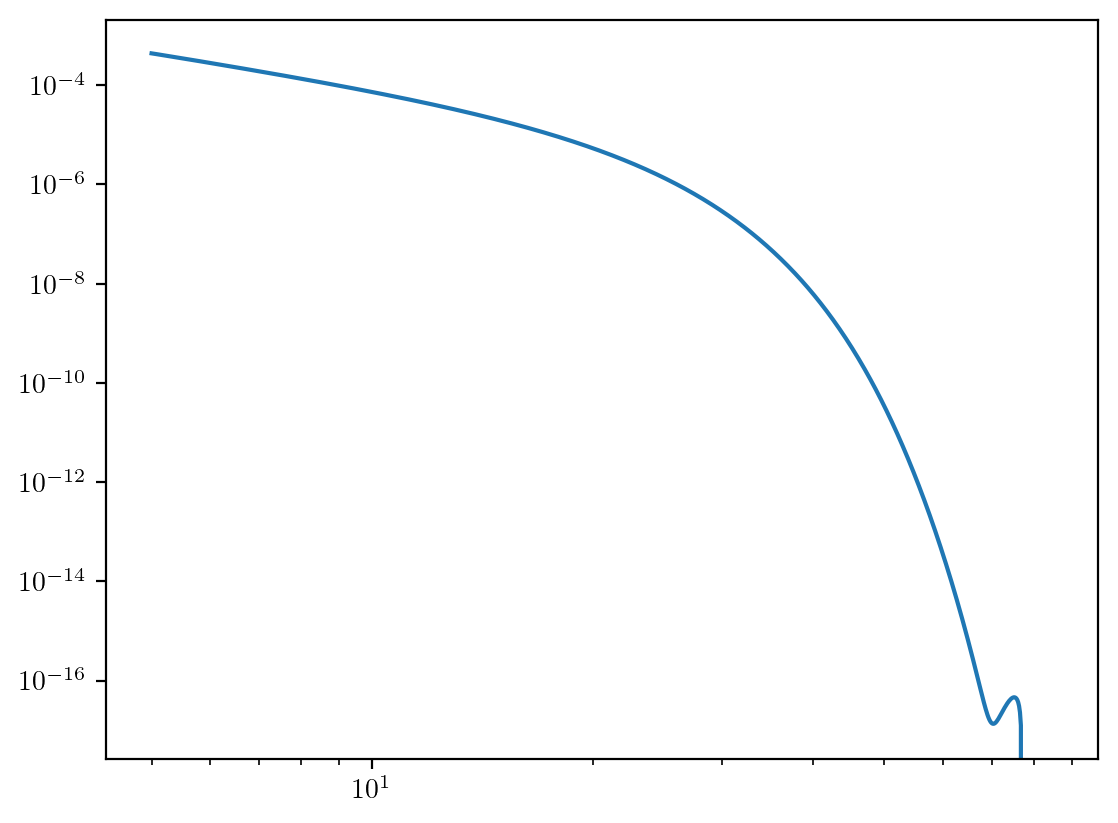

In [28]:
plt.loglog(R_array, VSF_model(1.25, k, P, B_slope=0.96, B_offset=0.26))

In [ ]:
'''Omega_M = 0.31
h       = 0.68
rho     = 2.775e11 * Omega_M * h**2
M = lambda R: 4/3*np.pi *rho * R**3
V = lambda R: M(R)/rho'''

In [ ]:
'''R_array = np.geomspace(5, 85, 1000)
M_array = M(R_array)
V_array = M_array/rho
r_L = lambda R: 5**(-1/3)*R
V_rL = V(r_L(R_array))
sigma_array = sigmaR(R_array)
dlnsigma_dM = CubicSpline(R_array, np.gradient(np.log(sigma_array), M_array))
dlnsigma_dR = CubicSpline(R_array, np.gradient(np.log(sigma_array), R_array))

dlnsigma_dlnM = lambda R: dlnsigma_dM(R)*M(R)
dlnsigma_dlnR = lambda R: dlnsigma_dR(R)*R'''

In [ ]:
1/(1+delta_v_lin)**(1/3)

In [ ]:
#plt.loglog(R_array, -dlnsigma_dR(R_array)*f_ln_sigma(R_array)/V(R_array))

In [ ]:
#plt.loglog(R_array, np.array([f_ln_sigma(R) for R in R_array]))

In [ ]:
'''voids        = np.loadtxt('2048Mpc_n4096_M13zobov-Voids_cat.txt', dtype=np.float32)
#np.loadtxt('testzobov-Voids_cat.txt').T
#vx, vy, vz   = voids[1:4]
vR           = voids[:,4]
vdelmin = voids[:,5] # central/minimum density
vdelavg = voids[:,6] # average void density'''

In [ ]:
#plt.hist(vdelavg, bins=50)

In [ ]:
'''bin_edges    = np.logspace(np.log10(15), np.log10(np.max(vR)/2.5), 11)
bin_cens     = np.logspace(np.log10(15), np.log10(np.max(vR)/2.5), 10)
hist_void    = np.histogram(vR/2.5, bins=bin_edges)
n_of_R_void  = np.cumsum(hist_void[0]/(2048*.68)**3)
dn_dlnR_void = np.gradient(n_of_R_void, np.log(bin_cens))

plt.loglog(bin_cens, dn_dlnR_void)
plt.loglog(R_array, -dlnsigma_dlnR(R_array)*V_rL/V_array * 
                      np.array([f_ln_sigma(R) for R in R_array])/V_array)
plt.grid()'''

In [99]:
new_radii_lcdm = np.loadtxt('test_new_radii_lcdm.dat')
new_radii_m25 = np.loadtxt('test_new_radii_m25.dat')

In [ ]:
#model = -dlnsigma_dlnR(R_array/1.62) * np.array([f_ln_sigma(R) for R in R_array])/V_array
#[(bin_edges[i+1]+bin_edges[i])/2 for i in range(10)] 

sigma8 = 0.8256903183974752
sigma8 = 0.8098979449216279


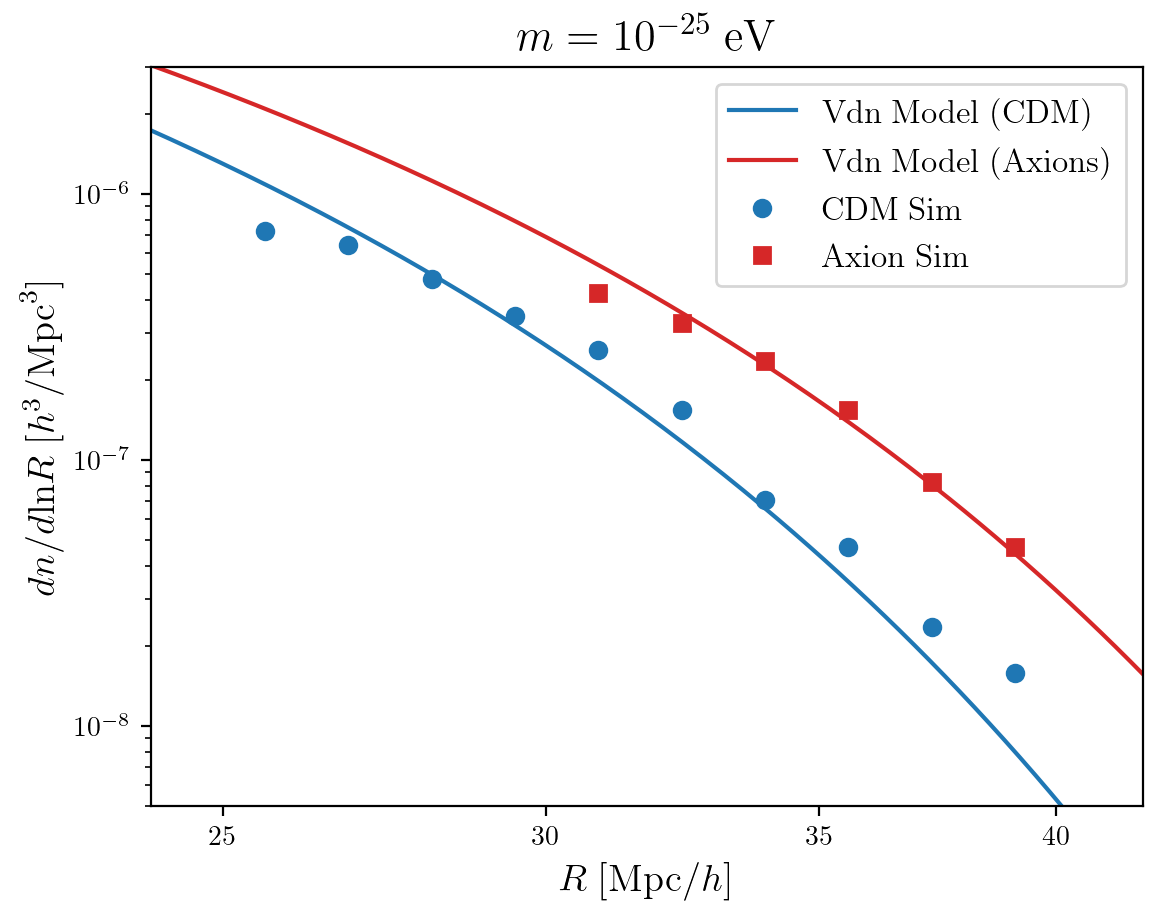

In [105]:
bin_edges    = np.geomspace(25, 40, 11)
bin_cens     = (bin_edges[:-1] + bin_edges[1:]) / 2
hist_void    = np.histogram(new_radii_lcdm, bins=bin_edges)
n_of_R_void  = np.cumsum(hist_void[0]/(2048*.68)**3)
dn_dlnR_void = np.gradient(n_of_R_void, np.log(bin_cens))

plt.loglog(R_array, VSF_model(1.24, k, P, B_slope=0.96, B_offset=0.26), 
           label='$\mathrm{Vdn\;Model\;(CDM)}$', c='C0')
plt.errorbar(bin_cens, dn_dlnR_void, fmt='o', label='$\mathrm{CDM\;Sim}$', c='C0')


bin_edges    = np.geomspace(25, 40, 11)
bin_cens     = (bin_edges[:-1] + bin_edges[1:]) / 2
hist_void    = np.histogram(new_radii_m25, bins=bin_edges)
n_of_R_void  = np.cumsum(hist_void[0]/(2048*.68)**3)
dn_dlnR_void = np.gradient(n_of_R_void, np.log(bin_cens))

plt.loglog(R_array, VSF_model(1.4, k, P*Tk25, B_slope=0.96, B_offset=0.26), 
           label='$\mathrm{Vdn\;Model\;(Axions)}$', c='C3')
plt.errorbar(bin_cens[4:], dn_dlnR_void[4:], fmt='s', 
             label='$\mathrm{Axion\;Sim}$', c='C3')

#plt.plot(R_array, model)
plt.yscale('log')
plt.xscale('log')
plt.xlim(24, 42)
plt.ylim(5e-9, 3e-6)
#plt.grid()
plt.xlabel('$R\;[\mathrm{Mpc}/h]$', fontsize=14)
plt.ylabel('$dn/d\mathrm{ln} R\;[h^3/\mathrm{Mpc}^3]$', fontsize=14)
plt.xticks(ticks=[25, 30, 35, 40], labels=['$25$', '$30$', '$35$', '$40$'])
plt.legend(loc=0, fontsize=12)
plt.title('$m=10^{-25}\;\mathrm{eV}$', fontsize=16)
plt.savefig('vsf_model_with_axions.png', dpi=400)

In [90]:
from mcfit import P2xi
#k, P = numpy.loadtxt('P.txt', unpack=True)
r, xi = P2xi(k)(P*Tk25)

/Users/alexlague/opt/anaconda3/lib/python3.9/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
/Users/alexlague/opt/anaconda3/lib/python3.9/site-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


In [76]:
r_sim, corr_sim = np.loadtxt('gg_corr_m25.dat')

In [77]:
from scipy.optimize import curve_fit

In [91]:
xi_interp = CubicSpline(r, r**2*xi)
xi_mod = lambda x, b: b**2*xi_interp(x)

bfit = curve_fit(xi_mod, r_sim[r_sim>20], (r_sim**2*corr_sim)[r_sim>20])[0]
bfit

array([1.42372328])

(0.0, 150.0)

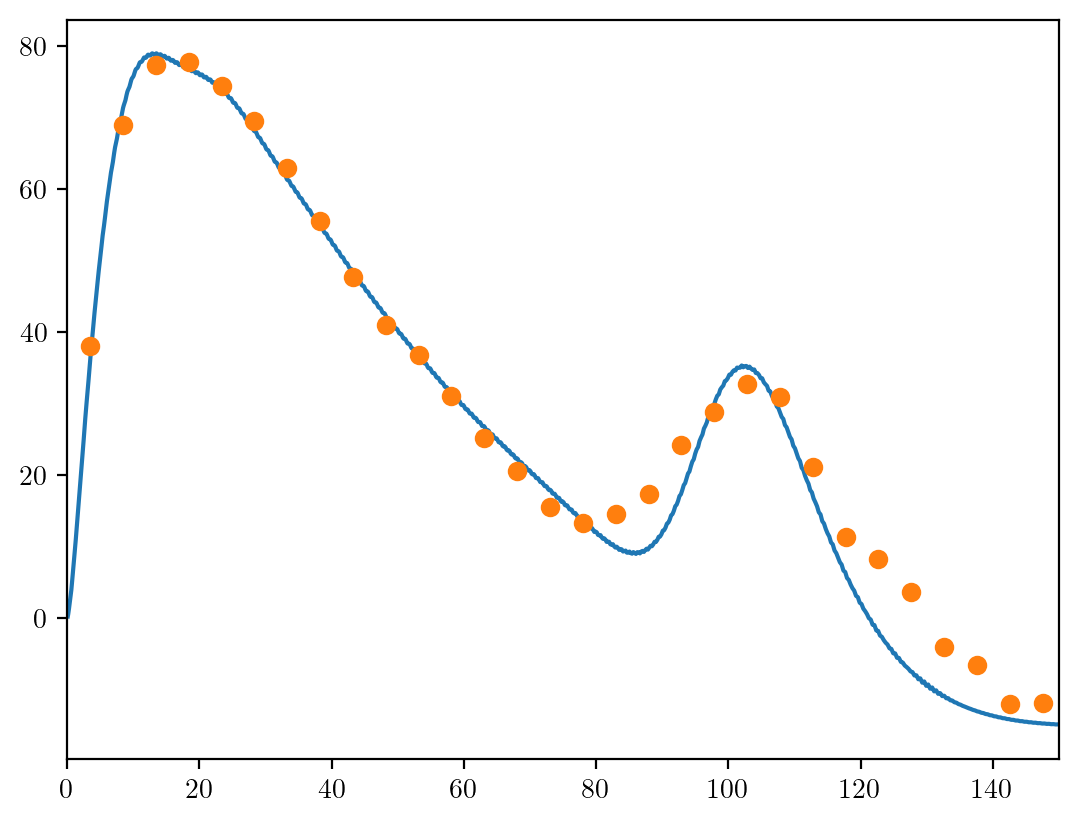

In [92]:
plt.plot(r, r**2*xi*bfit**2)
plt.plot(r_sim, r_sim**2*corr_sim, 'o')
plt.xlim(0, 150)

In [83]:
k25, pk25 = np.loadtxt('axioncamb_spectra/1_25_10_Planck18_matterpower.dat').T
k22, pk22 = np.loadtxt('axioncamb_spectra/1_22_10_Planck18_matterpower.dat').T

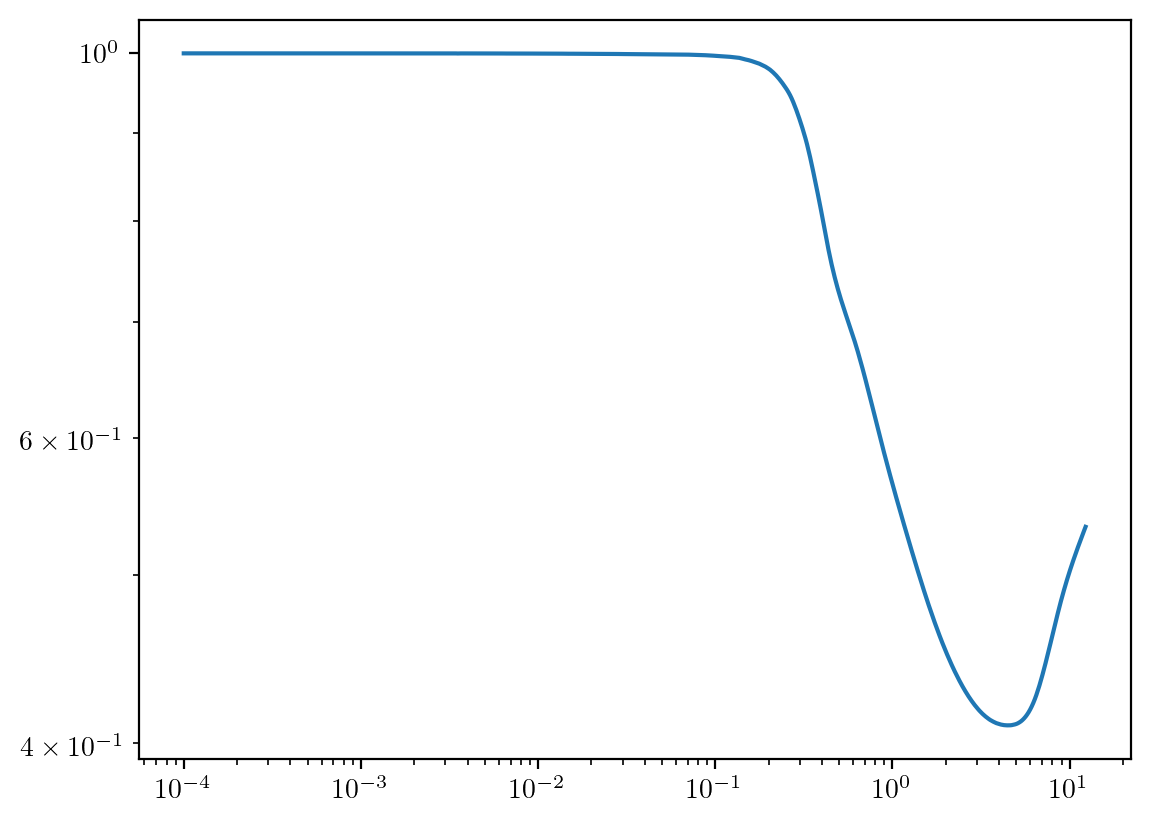

In [85]:
plt.loglog(k25, pk25/pk22)

In [88]:
Tk25 = CubicSpline(k25, pk25/pk22)(k)